In [130]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from IPython import display
import os
import tensorflow as tf
import torch 
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms



In [131]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    #plt.imshow(npimg,  cmap='gray')
    #fig.show(figsize=(1,1))
    
    fig, ax = plt.subplots(figsize=(1, 1))
    ax.imshow(npimg,  cmap='gray', interpolation='nearest')
    plt.show()

In [132]:
#(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

In [133]:
y_train[0].shape


()

5


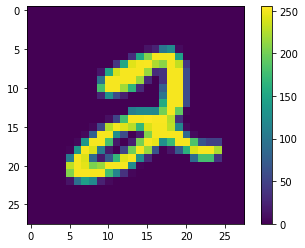

In [74]:
print(y_train[0])
plt.imshow(x_train[5, :, :])
plt.colorbar()

In [169]:
learning_rate = 0.001
epochs = 15
batch_size = 128

valid_ratio = 0.1

In [183]:
MNIST_train = torchvision.datasets.MNIST(root='/Users/laurieprelot/Documents/Projects/2020_probabilistic_AI/PAI_code/project2/data',
                           train=True, transform=transforms.ToTensor(), target_transform=None, download=True)

MNIST_test = torchvision.datasets.MNIST(root='/Users/laurieprelot/Documents/Projects/2020_probabilistic_AI/PAI_code/project2/data',
                           train=False, transform=transforms.ToTensor(), target_transform=None, download=True)

In [184]:
MNIST_test.data.shape

torch.Size([10000, 28, 28])

In [185]:
batch_size = 10
# dataset loader
train_loader = torch.utils.data.DataLoader(dataset=MNIST_train,
                                          batch_size=batch_size,
                                          drop_last=True)
test_loader = torch.utils.data.DataLoader(dataset=MNIST_test,
                                          batch_size=batch_size,
                                          drop_last=True)

In [178]:
class BasicCNN(nn.Module):
    
    def __init__(self):
        super(BasicCNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2))
        self.fc = nn.Linear(128*5*5, 10, bias=True) # Input, output size
    
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.shape[0], -1) # Flatten
        out = self.fc(out)
        softmaxes = F.softmax(out, dim=1)
        return softmaxes

In [179]:
class Loss_ECE(nn.Module):
    '''https://github.com/gpleiss/temperature_scaling/blob/master'''
    
    def __init__(self, n_bins=15):
        """
        n_bins (int): number of confidence interval bins
        """
        super(Loss_ECE, self).__init__()
        bin_lim = torch.linspace(0, 1, n_bins + 1)
        self.bin_lowers = bin_lim[:-1]
        self.bin_uppers = bin_lim[1:]

    def compute_ece(self, confidences, accuracies):
        ece = torch.zeros(1)
        for bin_low, bin_up in zip(self.bin_lowers, self.bin_uppers):
            # Calculated |confidence - accuracy| in each bin
            in_bin = confidences.gt(bin_low.item()) * confidences.le(bin_up.item())
            prop_in_bin = in_bin.float().mean()
            if prop_in_bin.item() > 0:
                accuracy_binned = accuracies[in_bin].float().mean()
                avg_confidence_binned = confidences[in_bin].mean()
                ece += torch.abs(avg_confidence_binned - accuracy_binned) * prop_in_bin
        return ece

In [180]:
class Model_deploy():
    def __init__(self, train_loader, test_loader, epochs):
        self.n_batches = len(train_loader)
        self.train_loader = train_loader
        self.test_loader = test_loader
        self.epochs = epochs
        self.best_valid = np.inf
        
        self.model = BasicCNN()
        self.criterion = nn.CrossEntropyLoss() #TODO ADD KL divergence
        self.optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        self.ece_criterion = Loss_ECE()
        
    def test_model(self): 

        test_loss = 0
        
        confidence_list = []
        accuracies_list = []

        with torch.no_grad():
            self.model.eval()
            for data, target in self.test_loader:
                output = model(data)
                logits_list.append(output)
                labels_list.append(target)
                
                # Loss Cross entropy
                loss = self.criterion(output, target, reduction='sum')  # sum up batch loss
                test_loss+= loss.item()
                
                # confidences , predicted label 
                confidences, predictions = torch.max(output, 1)
                accuracies = predictions.eq(target) #correct += pred.eq(target.view_as(pred)).sum().item()
                confidence_list.append(confidences)
                accuracies_list.append(accuracies)
            
            # ECE Loss
            ece_loss = ece_criterion(torch.cat(confidence_list), torch_cat(accuracies_list))
            correct = torch_cat(accuracies_list).sum().item()
            return test_loss, ece_loss, correct        

    def run_model(self):

        for epoch in range(self.epochs):
            avg_loss = 0
            for idx, data in enumerate(self.train_loader):
                X, Y = data
                
                ### Train model 
                # zero the parameter gradients
                self.optimizer.zero_grad() 
                
                # forward 
                pred = self.model(X)
                loss = self.criterion(pred, Y)
            
                #backward + optimize
                loss.backward()
                self.optimizer.step()
    
                avg_loss += loss / self.n_batches
                print(avg_loss)

            test_loss, ece_loss, correct = self.test_model()
            print('Epoch:{}, train loss:{:.5f}, valid loss:{:.5f}'.format(epoch, avg_loss, test_loss))
            print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%), ECE loss: {} \n'.format(
            test_loss, correct, len(test_loader.dataset),
            100. * correct / len(test_loader.dataset)), 
            ece_loss)

            if loss_valid < best_valid:
                #torch.save(model.state_dict(), './saves/basicCNN.pth')
                best_valid = loss_valid

In [186]:
Session = Model_deploy(train_loader ,test_loader 2)

In [187]:
Session.run_model()

RuntimeError: Given groups=1, weight of size [64, 3, 3, 3], expected input[10, 1, 28, 28] to have 3 channels, but got 1 channels instead

In [107]:
3200 * 10

32000